# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

./tiny-imagenet-200.zip


In [ ]:
train_folder = 'tiny-imagenet-200/train'
test_folder = 'tiny-imagenet-200/val'
test_annotations_file = 'val_annotations.txt'

batch_size = 250

In [ ]:
from pathlib import Path
import pandas as pd
import os

def get_train_labels(some_folder):
    annotations_dir = Path(some_folder)
    for folder in annotations_dir.iterdir():     
        for jpg_file in folder.glob('**/*.JPEG'):
            yield str(jpg_file), str(folder.name)
            
def get_test_labels(some_folder, annotations_file):
    filepath = os.path.join(some_folder, annotations_file)
    df = pd.read_csv(filepath, header=None, sep='\t')
    annotations_dir = Path(some_folder)     
    for jpg_file in annotations_dir.glob('**/*.JPEG'):
        class_name = df[df[0] == jpg_file.name][1]
        yield str(jpg_file), class_name.to_string(index=False)
        
train_img_metadata = pd.DataFrame(get_train_labels(train_folder), columns=['filename', 'labels'])
test_img_metadata = pd.DataFrame(get_test_labels(test_folder, test_annotations_file), columns=['filename', 'labels'])

In [ ]:
from keras.applications.resnet50 import preprocess_input

def preprocessing(img):
    #img = preprocess_input(img)
    return img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocessing)

train_generator = train_datagen.flow_from_dataframe(
    train_img_metadata,
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    x_col='filename',
    y_col='labels',
    target_size=(64, 64))

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocessing)

test_generator = test_datagen.flow_from_dataframe(
    test_img_metadata,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    x_col='filename',
    y_col='labels',
    target_size=(64, 64))

Found 100000 validated image filenames belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


(64, 64, 3)


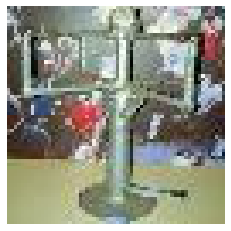

In [ ]:
plt.imshow(test_generator[0][0][0])
plt.axis("off")
print(test_generator[0][0][0].shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2

In [ ]:
def my_model(input_shape=(64, 64, 3), output_len=200):
    model = Sequential()

    model.add(ZeroPadding2D((2, 2), input_shape=input_shape))
    model.add(Conv2D(128, (7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (5, 5),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))     

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_len))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 68, 68, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 68, 68, 128)       18944     
_________________________________________________________________
batch_normalization (BatchNo (None, 68, 68, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 68, 68, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 128)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 128)       4

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    epochs=25,
    validation_data=test_generator,
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
400/400 [==============================] - 192s 479ms/step - loss: 4.6878 - accuracy: 0.0582 - val_loss: 8.7168 - val_accuracy: 0.0232
Epoch 2/25
400/400 [==============================] - 189s 474ms/step - loss: 3.8483 - accuracy: 0.1601 - val_loss: 4.2301 - val_accuracy: 0.1315
Epoch 3/25
400/400 [==============================] - 190s 476ms/step - loss: 3.4418 - accuracy: 0.2227 - val_loss: 3.8264 - val_accuracy: 0.1768
Epoch 4/25
400/400 [==============================] - 189s 474ms/step - loss: 3.1775 - accuracy: 0.2680 - val_loss: 3.5422 - val_accuracy: 0.2202
Epoch 5/25
400/400 [==============================] - 186s 465ms/step - loss: 2.9522 - accuracy: 0.3094 - val_loss: 3.2054 - val_accuracy: 0.2687
Epoch 6/25
400/400 [==============================] - 186s 464ms/step - loss: 2.7781 - accuracy: 0.3399 - val_loss: 3.5154 - val_accuracy: 0.2391
Epoch 7/25
400/400 [============================

Text(0.5, 0, 'epoch')

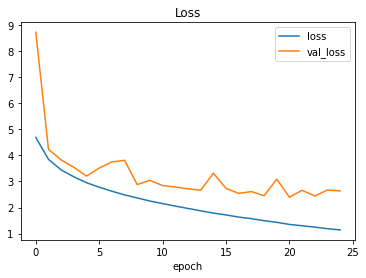

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

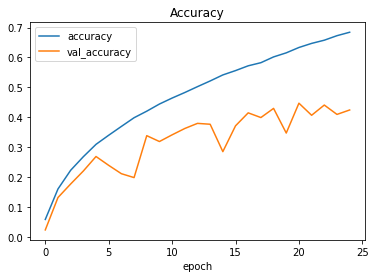

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
test_accuracy = model.evaluate_generator(generator=test_generator, verbose=0)[1]

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		42.43 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]